<a href="https://colab.research.google.com/github/gr3g-z/TCC-PUCSP-CDIA/blob/secondary/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extração dos Dados e Feature Engineering

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transactions = pd.read_csv('/content/drive/MyDrive/store_sales/transactions.csv')
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [5]:
# Carregar o DataFrame do arquivo pickle
df_clusterizado = pd.read_pickle('/content/drive/MyDrive/store_sales/df_clusterizado.pkl')
df_clusterizado = df_clusterizado.rename(columns={'loja': 'store_nbr'})
df_clusterizado

,store_nbr,Soma vendas totais,Contagem vendas totais,Media por venda,Dias com dados,Media do faturamento por dia,Media de vendas por dia,cluster
0,1,1.414501e+07,2553963,5.538456,1694,8350.066629,1507.652302,2
1,2,2.155739e+07,3219901,6.695047,1694,12725.731195,1900.768005,0
2,3,5.048191e+07,5366350,9.407122,1695,29782.837867,3165.988201,1
3,4,1.890970e+07,2519007,7.506807,1695,11156.165416,1486.139823,2
4,5,1.559240e+07,2347877,6.641065,1695,9199.058745,1385.178171,2
5,6,2.518368e+07,3065896,8.214134,1695,14857.628317,1808.788201,0
6,7,2.695205e+07,2995993,8.996032,1695,15900.914208,1767.547493,0
7,8,3.049429e+07,4637971,6.574920,1695,17990.729751,2736.266077,0
8,9,2.640944e+07,3516162,7.510872,1695,15580.791189,2074.431858,0
9,10,9.613906e+06,1652493,5.817819,1695,5671.920788,974.922124,2


In [6]:
# Merge dos DataFrames utilizando a coluna 'store_nbr' como chave de junção
transactions = pd.merge(transactions, df_clusterizado[['store_nbr', 'cluster']], on='store_nbr', how='left')
transactions.head()

,date,store_nbr,transactions,cluster
0,2013-01-01,25,770,2
1,2013-01-02,1,2111,2
2,2013-01-02,2,2358,0
3,2013-01-02,3,3487,1
4,2013-01-02,4,1922,2


In [7]:
transactions.isnull().any()

date            False
store_nbr       False
transactions    False
cluster         False
dtype: bool

In [8]:
transactions.isnull().values.any()

False

In [9]:
transactions.isnull().sum()  # Conta a quantidade de valores nulos (incluindo `nan`) em cada coluna

date            0
store_nbr       0
transactions    0
cluster         0
dtype: int64

In [10]:
# Criando um dicionário e agrupando os dataframes por cluster
transactions_clusters = {}
grouped = transactions.groupby('cluster')
for cluster, group in grouped:
    transactions_clusters[cluster] = group

df_pqn = transactions_clusters[2]# DF Pequeno Porte
df_gnd = transactions_clusters[1]# DF Grande Porte
df_med = transactions_clusters[0]# DF Médio Porte

# Modelo Prophet

## Loja de Grande Porte

In [11]:
df_gnd

,date,store_nbr,transactions,cluster
3,2013-01-02,3,3487,1
38,2013-01-02,44,4821,1
39,2013-01-02,45,4208,1
40,2013-01-02,46,4886,1
41,2013-01-02,47,4161,1
...,...,...,...,...
83478,2017-08-15,45,3685,1
83479,2017-08-15,46,3197,1
83480,2017-08-15,47,3581,1
83481,2017-08-15,48,2722,1


In [12]:
df_gnd['date'] = pd.to_datetime(df_gnd['date'])

In [13]:
# Criar um novo DataFrame filtrando os valores da coluna "store_nbr"
df_gnd = df_gnd[df_gnd['store_nbr'] == 44]

In [14]:
# Renomeie as colunas para o formato esperado pelo Prophet
df_gnd = df_gnd.rename(columns={'date': 'ds', 'transactions': 'y'})
df_gnd = df_gnd.drop(['store_nbr','cluster'], axis =1)

In [15]:
df_gnd.head()

,ds,y
38,2013-01-02,4821
84,2013-01-03,3618
130,2013-01-04,4169
176,2013-01-05,4921
222,2013-01-06,4925


DEBUG:cmdstanpy:input tempfile: /tmp/tmp104_mz5f/8b95y11j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp104_mz5f/1iw9uowx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33844', 'data', 'file=/tmp/tmp104_mz5f/8b95y11j.json', 'init=/tmp/tmp104_mz5f/1iw9uowx.json', 'output', 'file=/tmp/tmp104_mz5f/prophet_model8iz0yr51/prophet_model-20240416212208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


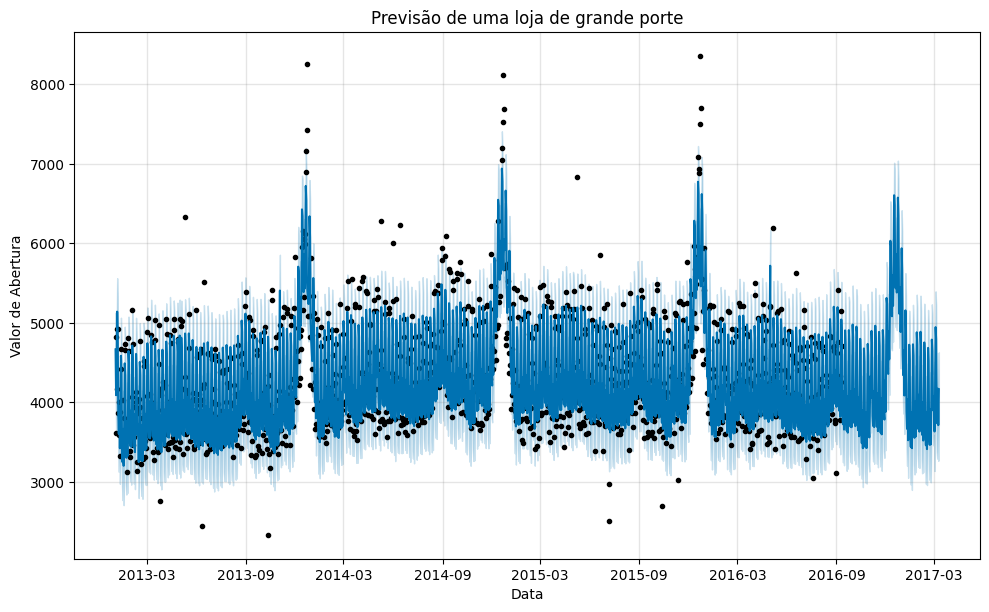

In [16]:
# Divisão para treino e teste
proporcao_treino = 0.8  # 80% de dados para treino
tamanho_treino = int(len(df_gnd) * proporcao_treino)

# Separação dos dados para treino e teste
df_train = df_gnd.iloc[:tamanho_treino]  # Dados de treino
df_test = df_gnd.iloc[tamanho_treino:]   # Dados de teste

# Ajustes do modelo Prophet
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.add_country_holidays(country_name='EC')
model.fit(df_train)

# Dataframe com as datas futuras (180 dias)
future = model.make_future_dataframe(periods=180)

# Previsão
forecast = model.predict(future)

# Visualizar as previsões
fig = model.plot(forecast)
plt.title('Previsão de uma loja de grande porte')
plt.xlabel('Data')
plt.ylabel('Valor de Abertura')
plt.show()

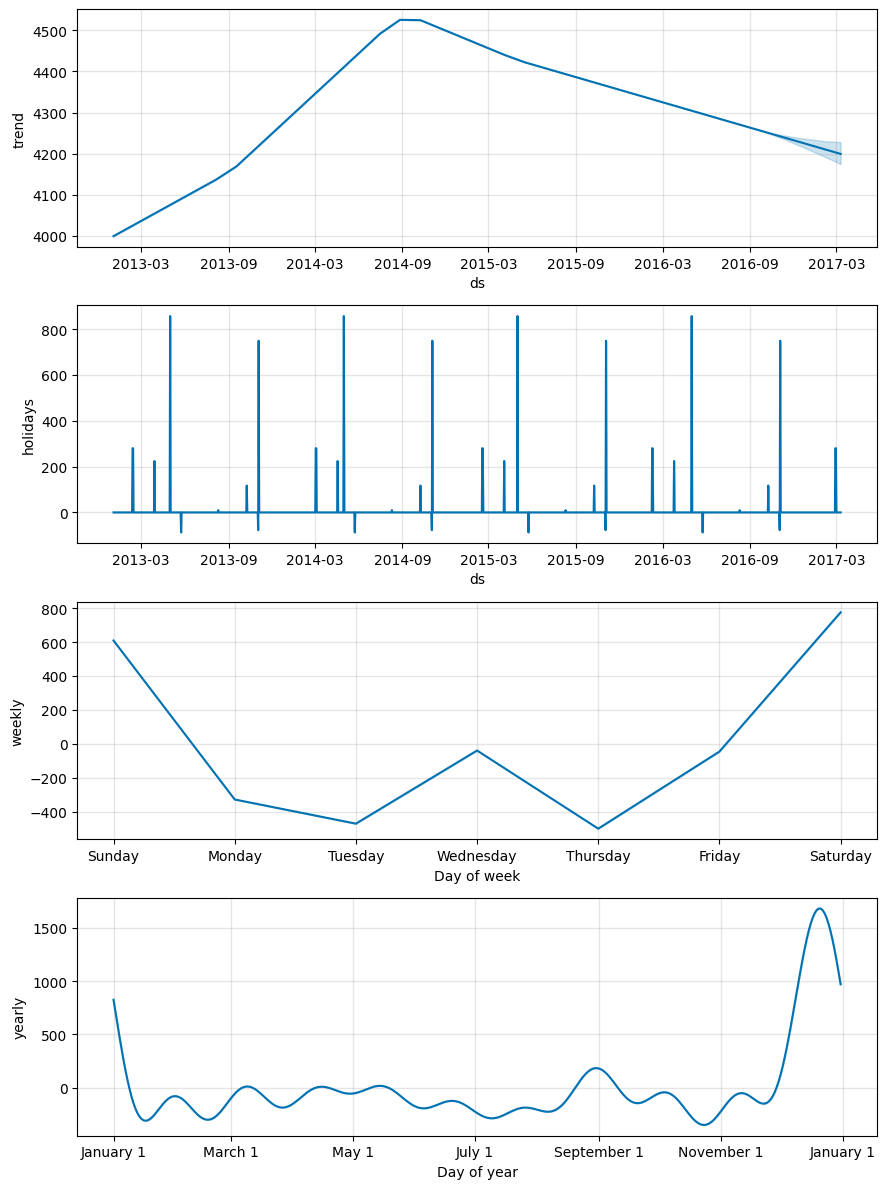

In [17]:
model.plot_components(forecast);

### Validação do Modelo

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

In [19]:
# Avaliando as previsões e comparando com os dados de teste
test_results = forecast[['ds', 'yhat']].iloc[-len(df_test):]
comparison_df = df_test.set_index('ds').join(test_results.set_index('ds'))
# Verificando se há valores ausentes
print(comparison_df.isna().sum())
comparison_df = comparison_df.dropna()

y         0
yhat    158
dtype: int64


In [20]:
# Calculo do RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(comparison_df['y'], comparison_df['yhat']))
print(f'RMSE: {rmse}')

# Calculo do MAE (Mean Absolute Error)
mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
print(f'MAE: {mae}')

# Filtro de valores zero em y e as correspondentes previsões yhat
valid_indices = comparison_df['y'] != 0
y_filtered = comparison_df['y'][valid_indices]
yhat_filtered = comparison_df['yhat'][valid_indices]

# Calculo do MAPE filtrado
mape = mean_absolute_percentage_error(y_filtered, yhat_filtered) * 100

print(f'MAPE: {mape}%')
#Acurácia Baseada no MAPE
accuracy = 100 - mape
print(f'Acurácia do modelo: {accuracy:.2f}%')

RMSE: 505.30280354416027
MAE: 367.09340055279654
MAPE: 7.5464921567456695%
Acurácia do modelo: 92.45%


## Loja de Pequeno Porte

In [21]:
df_pqn.head()

,date,store_nbr,transactions,cluster
0,2013-01-01,25,770,2
1,2013-01-02,1,2111,2
4,2013-01-02,4,1922,2
5,2013-01-02,5,1903,2
10,2013-01-02,10,1293,2


In [22]:
df_pqn.isnull().sum()

date            0
store_nbr       0
transactions    0
cluster         0
dtype: int64

In [23]:
df_pqn['date'] = pd.to_datetime(df_pqn['date'])

In [24]:
# Dataframe com a Loja de pequeno Porte escolhida
df_pqn = df_pqn[df_pqn['store_nbr'] == 31]

In [25]:
# Renomeando as colunas para o formato esperado pelo Prophet
df_pqn = df_pqn.rename(columns={'date': 'ds', 'transactions': 'y'})
df_pqn = df_pqn.drop(['store_nbr','cluster'], axis =1)

In [26]:
df_pqn.head()

,ds,y
27,2013-01-02,1401
73,2013-01-03,1126
119,2013-01-04,1246
165,2013-01-05,1317
211,2013-01-06,1468


DEBUG:cmdstanpy:input tempfile: /tmp/tmp104_mz5f/y1s3u455.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp104_mz5f/kdrdcgba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68475', 'data', 'file=/tmp/tmp104_mz5f/y1s3u455.json', 'init=/tmp/tmp104_mz5f/kdrdcgba.json', 'output', 'file=/tmp/tmp104_mz5f/prophet_modelgegeoos9/prophet_model-20240416212218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


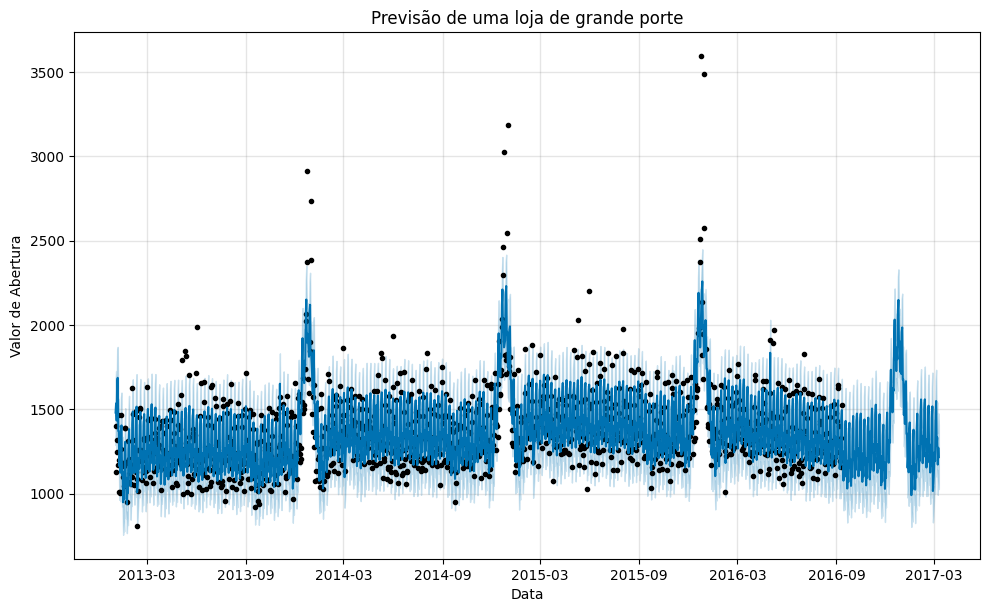

In [27]:
# Divisão para treino e teste
proporcao_treino = 0.8  # 80% de dados para treino
tamanho_treino = int(len(df_pqn) * proporcao_treino)

# Separando os dados de treino e teste
df_train = df_pqn.iloc[:tamanho_treino]  # Dados de treino
df_test = df_pqn.iloc[tamanho_treino:]   # Dados de teste

# Criando e ajustando o modelo Prophet
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.add_country_holidays(country_name='EC')
model.fit(df_train)

# Previsão
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# Visualizar as previsões
fig = model.plot(forecast)
plt.title('Previsão de uma loja de grande porte')
plt.xlabel('Data')
plt.ylabel('Valor de Abertura')
plt.show()

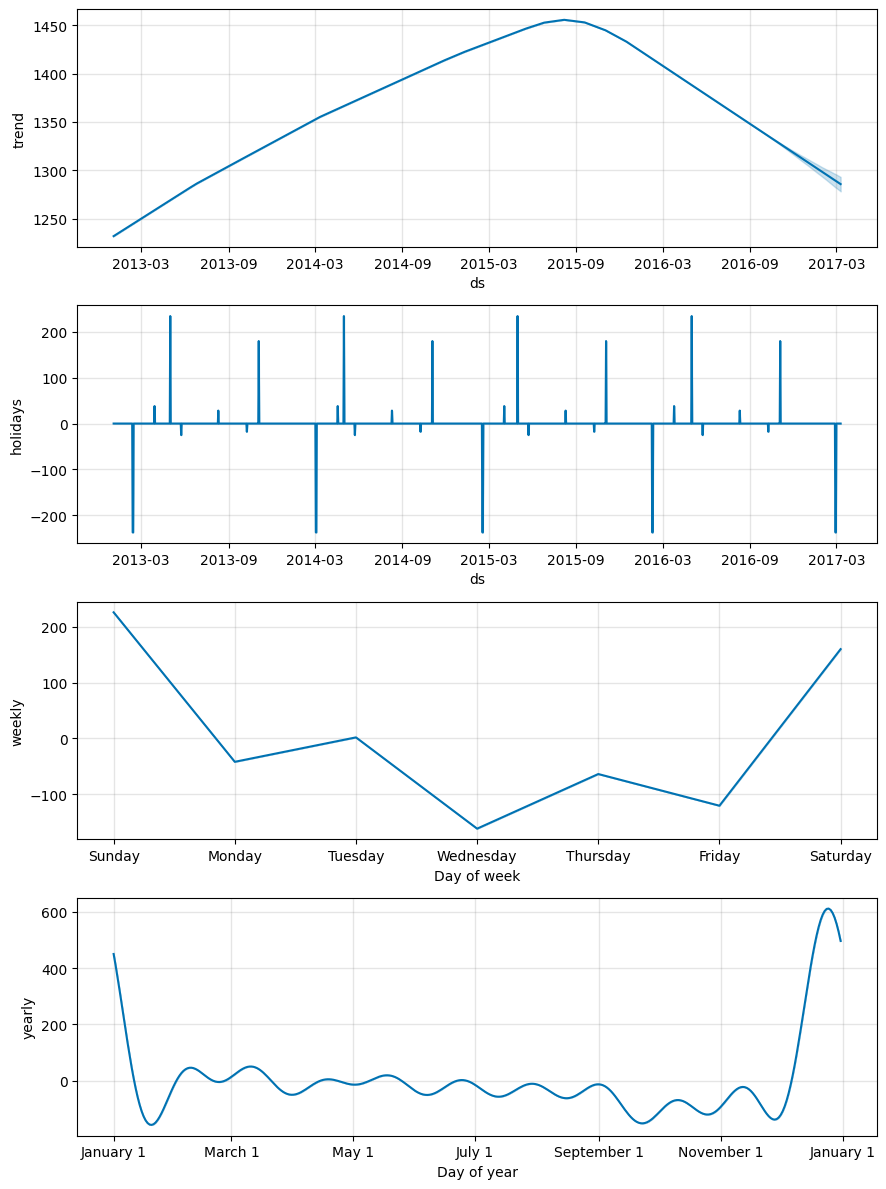

In [28]:
model.plot_components(forecast);

### Validação do Modelo

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

In [30]:
# Avaliando as previsões e comparando com os dados de teste
test_results = forecast[['ds', 'yhat']].iloc[-len(df_test):]
comparison_df = df_test.set_index('ds').join(test_results.set_index('ds'))

# Verificando se há valores ausentes
print(comparison_df.isna().sum())
comparison_df = comparison_df.dropna()

y         0
yhat    158
dtype: int64


In [31]:
# Calculo do RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(comparison_df['y'], comparison_df['yhat']))
print(f'RMSE: {rmse}')

# Calculo do MAE (Mean Absolute Error)
mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
print(f'MAE: {mae}')

# Filtrar valores zero em y e as correspondentes previsões yhat
valid_indices = comparison_df['y'] != 0
y_filtered = comparison_df['y'][valid_indices]
yhat_filtered = comparison_df['yhat'][valid_indices]

# Calculo do MAPE filtrado
mape = mean_absolute_percentage_error(y_filtered, yhat_filtered) * 100

print(f'MAPE: {mape}%')

# Calcule a acurácia como 100% menos o MAPE
accuracy = 100 - mape
print(f'Acurácia do modelo: {accuracy:.2f}%')

RMSE: 225.2136554382997
MAE: 140.22894260561011
MAPE: 8.98346403772882%
Acurácia do modelo: 91.02%
